In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import logging
from typing import Callable
from random import randint
import random
from collections import Counter

import numpy as np
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

LOGGER = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

# Chapter 2 of [Reinforcement learning](http://incompleteideas.net/book/RLbook2018.pdf)

Flags

In [57]:
NUM_ARMS = 10  # bandit arms
NUM_EXP = 2000  # number of experiment repetion to get statistically significant

Build bandit machine

In [2]:
class BanditMachine:
    """
    Armed bandit machine
    """
    def __init__(self, num_arms: int = 10, mean: float = 0, var: float = 1, var_action: float = 1):
        """
        Initialize bandit
        :param num_arms: number of arms
        :param mean: mean of distrubution to sample all actions
        :param var: variance of distrubution to sample all actions
        :param var_action: variance of distrubution of each action
        """
        LOGGER.debug(f'Initialize {num_arms} arms bandit machine')
        self._q = np.random.normal(mean, var, size=[num_arms])
        self._var_action = var_action
        self.optimal_action = np.argmax(self._q)
        
    def visualize_distribution(self, num_samples: int = 1000) -> None:
        """
        Visualize action distributions by sampling many times
        :param num_samples: number of samples
        """
        storage = []
        for ind, _ in enumerate(self._q):
            for _ in range(num_samples):
                tmp = {}
                tmp['action'] = ind
                tmp['reward'] = self.__call__(ind)
                storage.append(tmp)
                
        sns.violinplot(data=pd.DataFrame(storage), x='action', y='reward')
        
    def __call__(self, action: int) -> float:
        """
        Get reward
        :param action: action number
        """
        return np.random.normal(self._q[action], self._var_action)

Build solver

In [3]:
class Solver:
    """
    It defines solver logic
    """
    def __init__(self, f: Callable, steps: int = 1000, eps: float = .0):
        """
        Initialze solver
        :param f: the function to solve
        :param steps: number of steps to solve for
        :param eps: eps-greedy parameter
        """
        assert 0 <= eps <= 1
        LOGGER.debug(f'Initialize solver for {steps} steps and eps={eps}')
        self._eps = eps
        self._steps = steps
        self._f = f
        
    def do_step(self, q_sample_avg: np.array, step_num: np.array):
        """
        Do one iteration
        :param q_sample_avg: sample average of the rewards
        :param step_num: number of steps for each action (how many times the action was selected)
        """
        assert step_num.shape == q_sample_avg.shape
        
        # choose action
        num_actions = len(q_sample_avg)
        if np.random.uniform(0, 1) >= self._eps:  # greedy
            action = self.take_greedy(q_sample_avg)
        else:  # random
            action = randint(0, num_actions-1)
        
        # compute reward
        reward = self._f(action)
        
        # update accumulated reward
        step_num[action] += 1
        q_sample_avg[action] = q_sample_avg[action] + 1/step_num[action] * (reward - q_sample_avg[action])
        
        return reward, q_sample_avg, action, step_num
    
    def take_greedy(self, q_sample_avg: np.array) -> int:
        """
        Greedy strategy, select action based on max reward and break ties randomly
        :param q_sample_avg: sample average of the rewards
        """
        idxs = np.argwhere(q_sample_avg == np.max(q_sample_avg))
        
        return random.choice(idxs)[0]
    
    def run(self, init_cond: np.array):
        """
        Run experiment
        :param init_cond: Initial condition for the reward averages
        """
        current_state = init_cond.copy()
        steps = np.zeros(current_state.shape)
        out, actions = [], []
        for _ in range(2, self._steps+1):
            reward, current_state, action, steps = self.do_step(current_state, steps)
            out.append(reward)
            actions.append(action)
            
        return np.array(out), np.stack(actions) == self._f.optimal_action

Check if bandit machine makes sense by visualizing reward distribution (figure 2.1)

### 2.3 The 10-armed Testbed

8

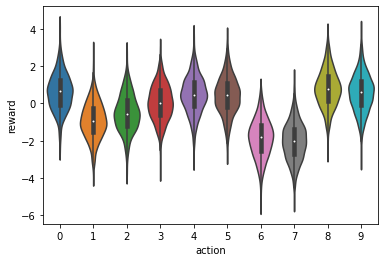

In [4]:
bandit = BanditMachine(NUM_ARMS)  # create bandit machine with ten arms
bandit.visualize_distribution()  # visualize distributions
bandit.optimal_action

### 2.4 Incremental Implementation and (figure 2.2)
* Check average reward across many experiments.
* Check influence of changing $\varepsilon$, the parameters of $\varepsilon$-greedy (there is an optimum $\varepsilon$).

INFO:__main__:Experiments with eps=0


eps=0:   0%|          | 0/2000 [00:00<?, ?it/s]

INFO:__main__:Experiments with eps=0.01


eps=0.01:   0%|          | 0/2000 [00:00<?, ?it/s]

INFO:__main__:Experiments with eps=0.1


eps=0.1:   0%|          | 0/2000 [00:00<?, ?it/s]

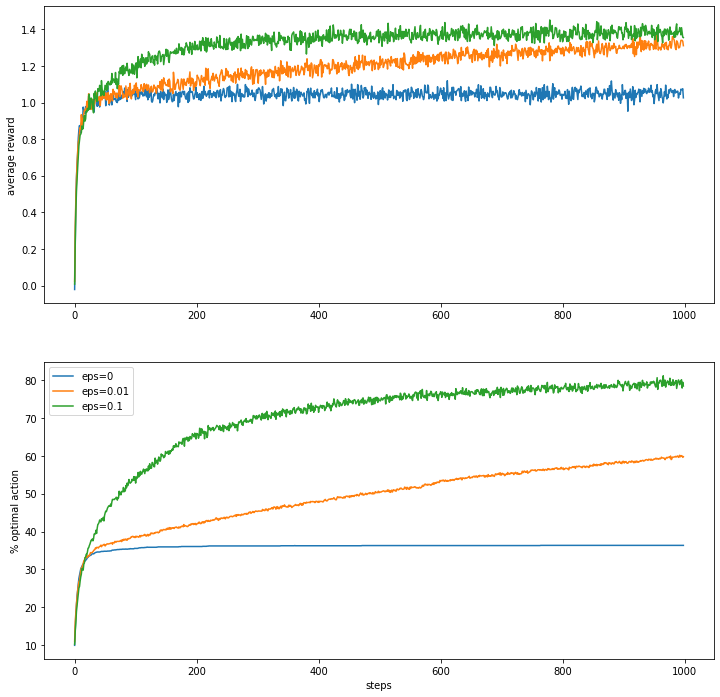

In [5]:
# num_arms = 10
_, axs = plt.subplots(2, 1, figsize=(12, 12))
for eps in [0, 0.01, 0.1]:
    LOGGER.info(f'Experiments with eps={eps}')
    rewards, optimals = [], []
    for _ in tqdm(range(2000), desc=f'eps={eps}'):
        solver = Solver(BanditMachine(num_arms), eps=eps, steps=1000)
        reward, optimal = solver.run(np.zeros(num_arms))
        rewards.append(reward)
        optimals.append(optimal)
            
    rewards = np.stack(rewards)
    optimals = np.array(optimals)
    axs[0].plot(rewards.mean(axis=0), label=f'eps={eps}')
    axs[1].plot(100*optimals.mean(axis=0), label=f'eps={eps}')
axs[0].set_ylabel('average reward')
axs[1].set_xlabel('steps')
axs[1].set_ylabel('% optimal action')
plt.legend()

### 2.5 Tracking a Nonstationary Problem (Exercise 2.5)
"Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation 0.01 to all the $q_*(a)$ on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha$ =0.1. Use $\varepsilon$ =0.1 and longer runs, say of 10,000 steps."

In [6]:
class BanditRandom:
    """
    Armed bandit machine with random drift of reward
    """
    def __init__(self, num_arms: int = 10):
        """
        Initialize bandit
        :param num_arms: number of arms
        """
        self._q = np.zeros(num_arms)
        self.optimal_action = np.argmax(self._q)
        
    def update_q(self):
        """
        Random addition to rewards
        """
        self._q += np.random.normal(0, .01, self._q.shape)
        self.optimal_action = np.argmax(self._q)
        
    def visualize_distribution(self, num_samples: int = 1000) -> None:
        """
        Visualize action distributions by sampling many times
        :param num_samples: number of samples
        """
        storage = []
        for _ in range(num_samples):
            self.__call__(0)
            tmp = [{'action': ind, 'reward': val} for ind, val in enumerate(self._q)]
            storage.extend(tmp)
                
        sns.violinplot(data=pd.DataFrame(storage), x='action', y='reward')
        
    def __call__(self, action: int) -> float:
        """
        Get reward
        :param action: action number
        """
        self.update_q()
        return self._q[action]


class SolverConstant(Solver):
    """
    Solver logic with constant update
    """
    def __init__(self, f: Callable, eps: float, alpha: float, steps: int = 1000):
        """"""
        super().__init__(f=f, steps=steps, eps=eps)
        self._alpha = alpha
        
    def do_step(self, q_sample_avg: np.array, step_num: np.array):
        """
        Do one iteration
        :param q_sample_avg: sample average of the rewards
        :param step_num: number of steps for each action (how many times the action was selected)
        """
        assert step_num.shape == q_sample_avg.shape
        alpha = self._alpha
        
        # choose action
        num_actions = len(q_sample_avg)
        if np.random.uniform(0, 1) >= self._eps:  # greedy
            action = self.take_greedy(q_sample_avg)
        else:  # random
            action = randint(0, num_actions-1)
        
        # compute reward
        reward = self._f(action)
        
        # update accumulated reward
        q_sample_avg[action] = q_sample_avg[action] + alpha * (reward - q_sample_avg[action])
        step_num[action] += 1
        
        return reward, q_sample_avg, action, step_num

Text(0.5, 1.0, 'Random drift')

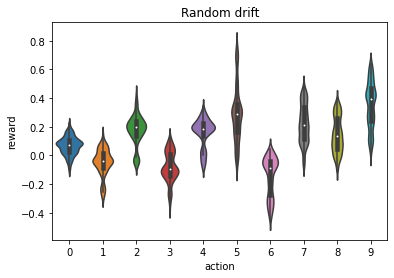

In [7]:
BanditRandom().visualize_distribution()
plt.title('Random drift')

Incremental update:   0%|          | 0/2000 [00:00<?, ?it/s]

Constant update:   0%|          | 0/2000 [00:00<?, ?it/s]

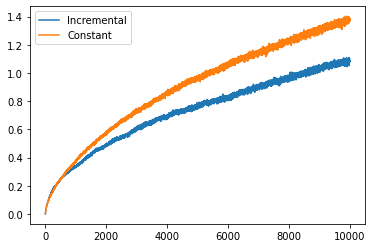

In [8]:
# incremental
rewards = []
for _ in tqdm(range(2000), desc='Incremental update'):
    solver = Solver(BanditRandom(), eps=0.1, steps=10000)
    reward, _ = solver.run(np.zeros(num_arms))
    rewards.append(reward)
            
ans = np.stack(rewards)
plt.plot(ans.mean(axis=0), label='Incremental')
plt.legend()

# constant
rewards = []
for _ in tqdm(range(2000), desc='Constant update'):
    solver = SolverConstant(BanditRandom(), eps=0.1, steps=10000, alpha=0.1)
    reward, _ = solver.run(np.zeros(num_arms))
    rewards.append(reward)
            
ans = np.stack(rewards)
plt.plot(ans.mean(axis=0), label='Constant')
plt.legend()

### 2.6 Optimistic Initial Values
Reproduce Figure 2.3 describing optimistic initial condition: impose bias to trigger exploration.

Optimistic initial, greedy:   0%|          | 0/2000 [00:00<?, ?it/s]

Realistic, e-greedy:   0%|          | 0/2000 [00:00<?, ?it/s]

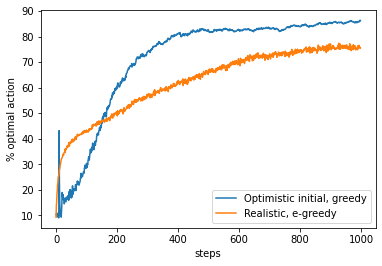

In [12]:
# Optimistic initial, greedy
optimals = []
for _ in tqdm(range(2000), desc='Optimistic initial, greedy'):
    solver = SolverConstant(BanditMachine(), eps=0, steps=1000, alpha=.1)
    _, optimal = solver.run(np.zeros(num_arms)+5)
    optimals.append(optimal)
            
optimals = np.stack(optimals)
plt.plot(100*optimals.mean(axis=0), label='Optimistic initial, greedy')
plt.legend()

# Realistic, e-greedy
optimals = []
for _ in tqdm(range(2000), desc='Realistic, e-greedy'):
    solver = SolverConstant(BanditMachine(), eps=0.1, steps=1000, alpha=.1)
    _, optimal = solver.run(np.zeros(num_arms))
    optimals.append(optimal)
            
optimals = np.stack(optimals)
plt.plot(100*optimals.mean(axis=0), label='Realistic, e-greedy')
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

### 2.7 Upper-Confidence-Bound Action Selection

In [10]:
class SolverUCB(Solver):
    """
    Solver logic with constant update
    """
    def __init__(self, f: Callable, c: float, steps: int = 1000):
        """"""
        super().__init__(f=f, steps=steps, eps=0)
        self._c = c
        self._step_count = 0
        
    def take_ucb(self, q_sample_avg: np.array, step_num: np.array) -> int:
        """"""
        tmp = step_num.copy()
        tmp[tmp == 0] = 1e-10
        value = q_sample_avg + self._c * np.sqrt(np.log(self._step_count)/tmp)
        idxs = np.argwhere(value == np.max(value))
        
        return random.choice(idxs)
        
    def do_step(self, q_sample_avg: np.array, step_num: np.array):
        """
        Do one iteration
        :param q_sample_avg: sample average of the rewards
        :param step_num: number of steps for each action (how many times the action was selected)
        """
        self._step_count += 1
        assert step_num.shape == q_sample_avg.shape
        
        # choose action
        action = self.take_ucb(q_sample_avg, step_num)
        
        # compute reward
        reward = self._f(action)
        
        # update accumulated reward
        step_num[action] += 1
        q_sample_avg[action] = q_sample_avg[action] + 1/step_num[action] * (reward - q_sample_avg[action])
        
        return reward, q_sample_avg, action, step_num

eps-greedy:   0%|          | 0/2000 [00:00<?, ?it/s]

UCB:   0%|          | 0/2000 [00:00<?, ?it/s]

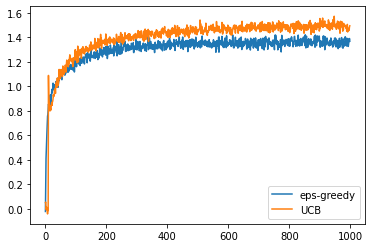

In [11]:
# eps-greedy
# num_arms = 10
rewards = []
for _ in tqdm(range(2000), desc='eps-greedy'):
    solver = Solver(BanditMachine(), eps=0.1, steps=1000)
    reward, _ = solver.run(np.zeros(num_arms))
    rewards.append(reward)
            
ans = np.stack(rewards)
plt.plot(ans.mean(axis=0), label='eps-greedy')
plt.legend()

# UCB
rewards = []
for _ in tqdm(range(2000), desc='UCB'):
    solver = SolverUCB(BanditMachine(), steps=1000, c=2)
    reward, _ = solver.run(np.zeros(num_arms))
    rewards.append(reward)
            
ans = np.stack(rewards)
plt.plot(ans.mean(axis=0), label='UCB')
plt.legend()

### 2.8 Gradient Bandit Algorithms

### 2.10 Summary (Parametric Study)

eps-greedy:   0%|          | 0/6 [00:00<?, ?it/s]

UCB:   0%|          | 0/7 [00:00<?, ?it/s]

greedy optimistic:   0%|          | 0/5 [00:00<?, ?it/s]

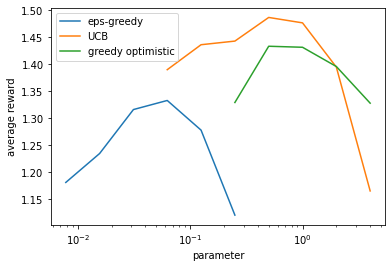

In [58]:
# eps-greedy
rewards = []
for eps in tqdm(range(-7, -1), desc='eps-greedy'):
    eps = 2 ** eps
    reward_mean = []
    for _ in range(NUM_EXP):
        solver = Solver(BanditMachine(), eps=eps, steps=1000)
        reward, _ = solver.run(np.zeros(num_arms))
        reward_mean.append(np.mean(reward))
    rewards.append((eps, np.mean(reward_mean)))
    
plt.semilogx(*list(zip(*rewards)), label='eps-greedy')

    
# UCB
rewards = []
for c in tqdm(range(-4, 3), desc='UCB'):
    c = 2 ** c
    reward_mean = []
    for _ in range(NUM_EXP):
        solver = SolverUCB(BanditMachine(num_arms=NUM_ARMS), c=c, steps=1000)
        reward, _ = solver.run(np.zeros(NUM_ARMS))
        reward_mean.append(np.mean(reward))
    rewards.append((c, np.mean(reward_mean)))

plt.semilogx(*list(zip(*rewards)), label='UCB')

# greedy optimistic
rewards = []
for q_0 in tqdm(range(-2, 3), desc='greedy optimistic'):
    q_0 = 2 ** q_0
    reward_mean = []
    for _ in range(NUM_EXP):
        solver = SolverConstant(BanditMachine(num_arms=NUM_ARMS), alpha=.1, steps=1000, eps=0)
        reward, _ = solver.run(np.zeros(NUM_ARMS)+q_0)
        reward_mean.append(np.mean(reward))
    rewards.append((q_0, np.mean(reward_mean)))

plt.semilogx(*list(zip(*rewards)), label='greedy optimistic')
plt.ylabel('average reward')
plt.xlabel('parameter')
plt.legend()